In [1]:
# import the relevant libraries.
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime

In [3]:
# Set the plotting font size
plt.rcParams.update({'font.size': 20})

# Set up a date-locator
locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
formatter = mdates.ConciseDateFormatter(locator)

In [4]:
# Get the data from Octopus Energy.
energy = pd.read_csv('octopus/octopus.csv')

# Extract some time variables.
energy['Date'] = pd.to_datetime(energy['Date'], format='%Y-%m-%d %H:%M:%S')
energy['Week'] = energy.Date.dt.week
energy['Date_'] = energy.Date.dt.date

# Create a new time-variable, which holds the day of the week and the time, for simpler plotting.
week_time = []
for date_time in energy.Date:
    week_time.append(datetime.timedelta(days=date_time.dayofweek, hours=date_time.hour, minutes=date_time.minute))
energy['Weektime'] = week_time

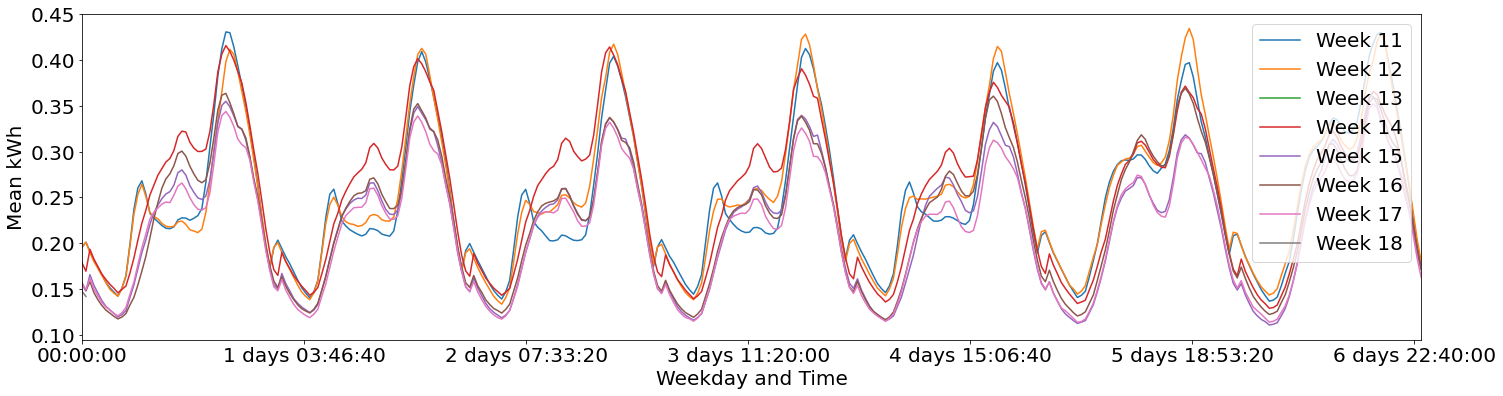

In [5]:
# Plot the electricity use data.
fig, ax = plt.subplots(figsize=(24,6))

# Loop through the different weeks to get a new plot for each week.
for week, week_data in energy.groupby('Week'):
    week_data.plot('Weektime', 'Electricity', ax=ax, label='Week {}'.format(week))

ax.set_xlabel('Weekday and Time'); ax.set_ylabel('Mean kWh')
plt.legend(loc=1)
plt.show()

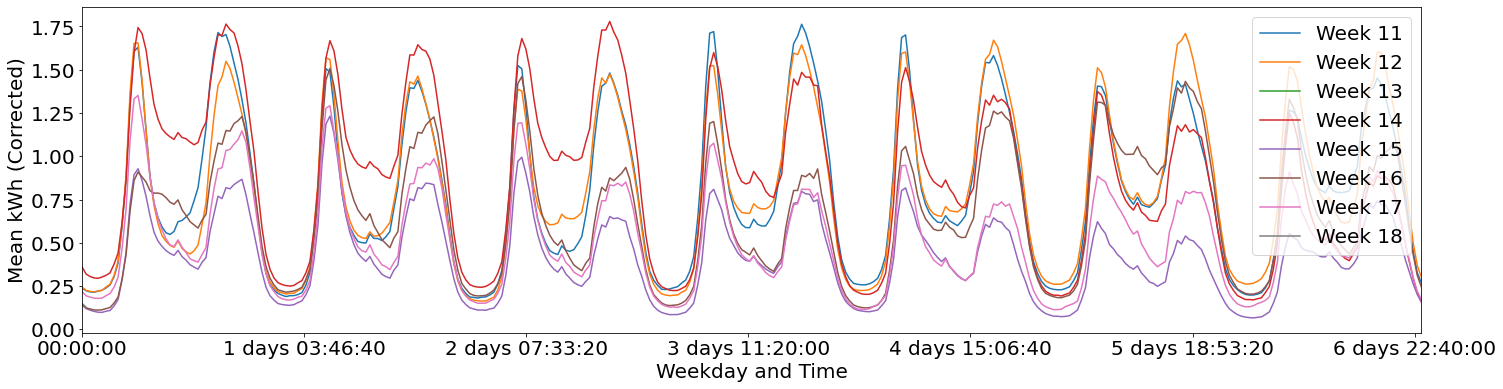

In [6]:
# PLot the gas use data.
fig, ax = plt.subplots(figsize=(24,6))

# Loop through the weeks to get a new plot for each week.
for week, week_data in energy.groupby('Week'):
    week_data.plot('Weektime', 'Gas (corrected)', ax=ax, label='Week {}'.format(week))
ax.set_xlabel('Weekday and Time'); ax.set_ylabel('Mean kWh (Corrected)')
plt.legend(loc=1)
plt.show()

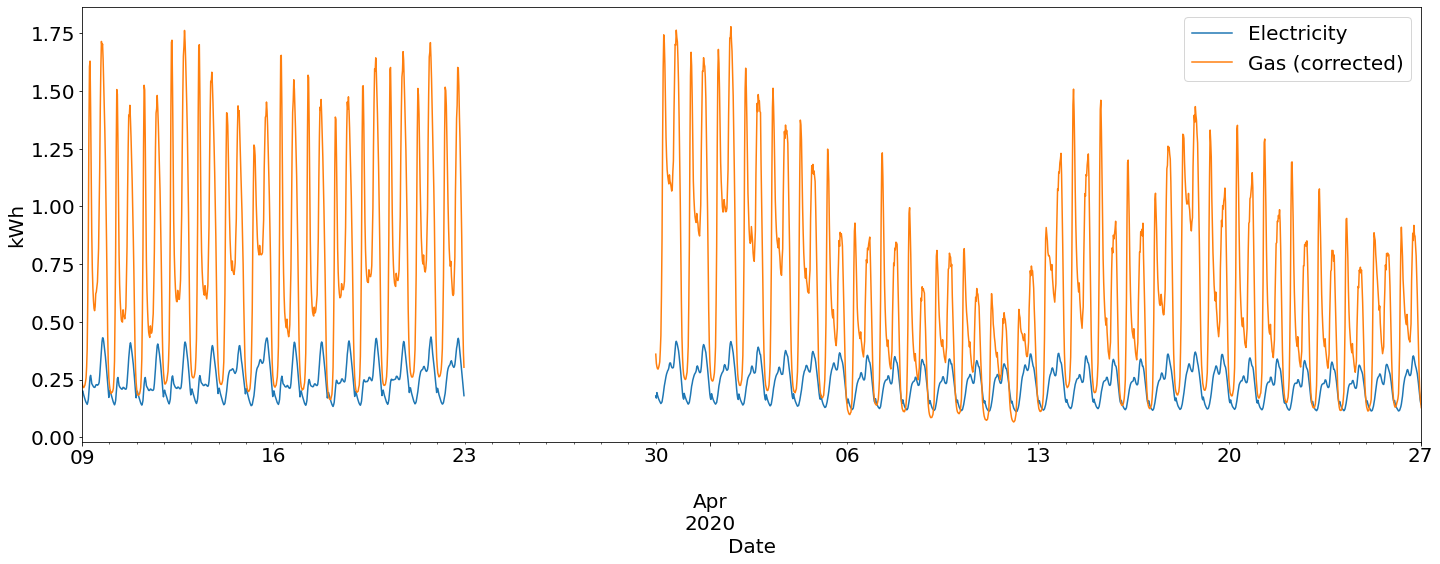

In [7]:
# Plot the gas and electrivity use for the whole period in a single plot.
ax=energy.plot('Date', ['Electricity', 'Gas (corrected)'], figsize=(24,8))
ax.set_ylabel('kWh')
plt.show()

In [8]:
# Get the average daily total energy consumption for both electricity and gas.
energy_average = energy.groupby('Date_').agg(electricity_daily_total = pd.NamedAgg('Electricity', 'sum'),
                                             gas_daily_total = pd.NamedAgg('Gas (corrected)', 'sum')).reset_index()

# Drop the last date, since that only had a few measurements, so it does not compare to the others.
energy_average.drop(energy_average.tail(1).index,inplace=True)
cols = ['electricity_daily_total','gas_daily_total']
energy_average[cols] = energy_average[cols].replace({0.0:np.nan})

# Get the weather data for each of the dates.
weather = pd.read_csv('octopus/UK_weather.csv')
weather.date = pd.to_datetime(weather['date'], format='%d/%m/%Y')
energy_average = energy_average.join(weather)

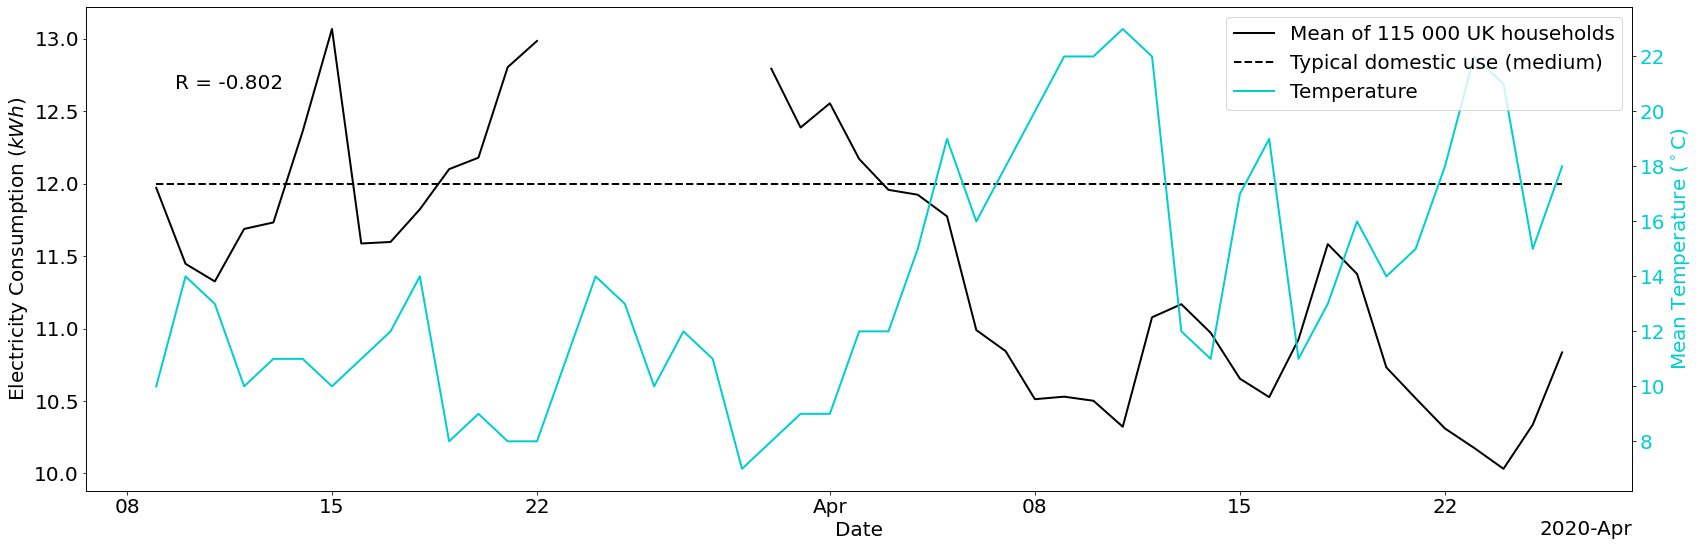

In [9]:
# Plot the electricity use, the typical domestic electricity use (8-10 kWh per day) and the temperature in degress Celcius.
fig, ax1 = plt.subplots(figsize=(24,8))

# Plot the average daily electricity use and the typical (high) as a dotted line.
color = 'k'
ax1.set_xlabel('Date'); ax1.xaxis.set_major_locator(locator); ax1.xaxis.set_major_formatter(formatter)
ax1.set_ylabel('Electricity Consumption $(kWh)$', color=color)
#fill = ax1.fill_between(energy_average['Date_'], 8.5*np.ones(len(energy_average)), 10*np.ones(len(energy_average)), color='k', alpha=0.2)
electricity_mean = ax1.plot(energy_average['Date_'], 12*np.ones(len(energy_average)), c='k', linestyle='dashed', linewidth=2)
electricity = ax1.plot(energy_average['Date_'], energy_average['electricity_daily_total'], c='k', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

# Get another y-axis.
ax2 = ax1.twinx() 
   
# Plot the temperature
color = 'darkturquoise'
ax2.xaxis.set_major_locator(locator); ax2.xaxis.set_major_formatter(formatter)
ax2.set_ylabel('Mean Temperature ($^\\circ$C)', color=color)  # we already handled the x-label with ax1
temp = ax2.plot(energy_average['Date_'], energy_average['temperature'], color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Put the correlation coefficient as text in the plot
plt.text(0.01, 0.9, 'R = {0:.3f}'.format(energy_average[['electricity_daily_total', 'temperature']].corr(method='pearson').values[1,0]), ha='center', va='center', transform=ax.transAxes)

# Put a custom legend.
plt.legend([electricity[0], electricity_mean[0], temp[0]], ['Mean of 115 000 UK households', 'Typical domestic use (medium)', 'Temperature'], loc=1)

fig.tight_layout()
plt.show()

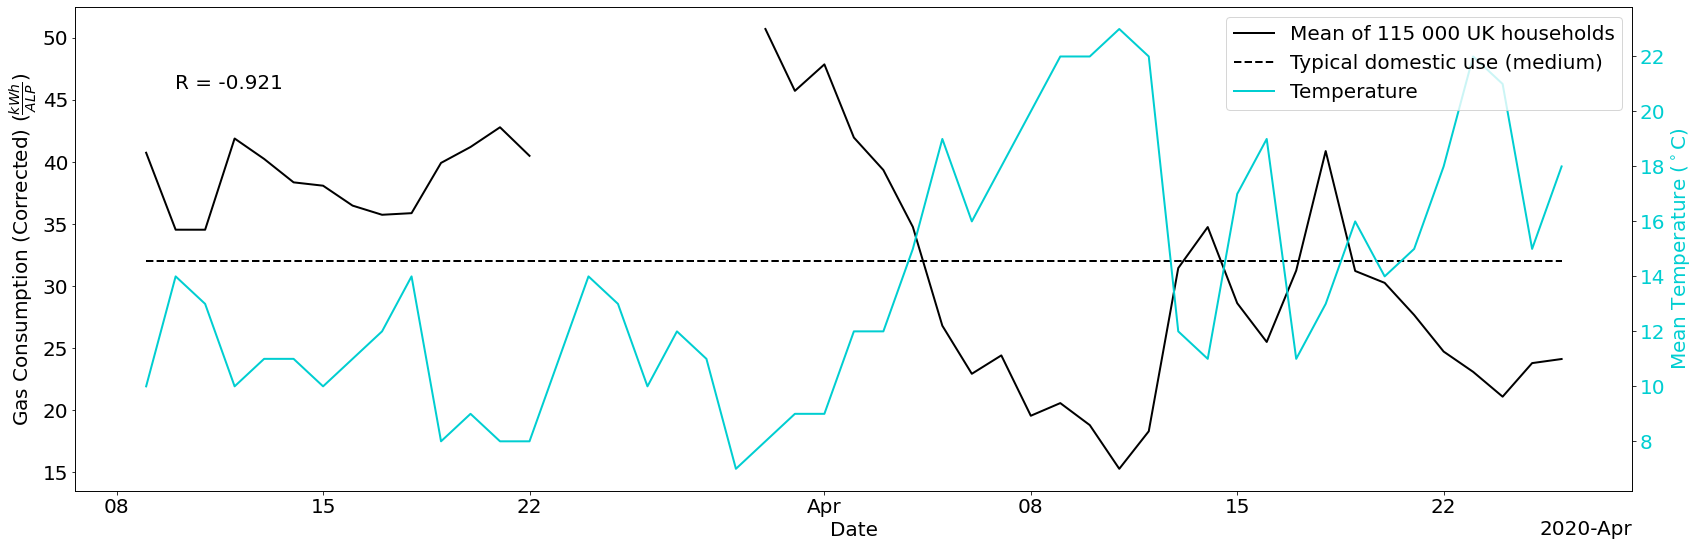

In [10]:
# Plot the gas use, the typical domestic gas use (32 kWh per day) and the temperature in degress Celcius.
fig, ax1 = plt.subplots(figsize=(24,8))

# Plot the average daily gas use and the typical (medium) as a dotted line.
color = 'k'
ax1.set_xlabel('Date'); ax1.xaxis.set_major_locator(locator); ax1.xaxis.set_major_formatter(formatter)
ax1.set_ylabel('Gas Consumption (Corrected) $(\\frac{kWh}{ALP})$', color=color)
gas_mean = ax1.plot(energy_average['Date_'], 32*np.ones(len(energy_average)), c='k', linestyle='dashed', linewidth=2)
gas = ax1.plot(energy_average['Date_'], energy_average['gas_daily_total'], color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

# get another y-axis.
ax2 = ax1.twinx()

# PLot the temperature.
color = 'darkturquoise'
ax2.xaxis.set_major_locator(locator); ax2.xaxis.set_major_formatter(formatter)
ax2.set_ylabel('Mean Temperature ($^\\circ$C)', color=color)  # we already handled the x-label with ax1
temp = ax2.plot(energy_average['Date_'], energy_average['temperature'], color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Put the correlation coefficient as text in the plot
plt.text(0.01, 0.9, 'R = {0:.3f}'.format(energy_average[['gas_daily_total', 'temperature']].corr(method='pearson').values[1,0]), ha='center', va='center', transform=ax.transAxes)

# Plot a custom legend.
plt.legend([gas[0], gas_mean[0], temp[0]], ['Mean of 115 000 UK households', 'Typical domestic use (medium)', 'Temperature'], loc=1)

fig.tight_layout()
plt.show()

[(0.8865144741387803, -10), (0.8999416626413184, -9), (0.9137269895312259, -8), (0.9276669319788832, -7), (0.9413981313413782, -6), (0.9545056266038419, -5), (0.9665185069826778, -4), (0.9769349194284546, -3), (0.9852077625912032, -2), (0.9902770810545113, -1), (0.992054927186954, 0), (0.9878272215442456, 1), (0.980799594370382, 2), (0.97175283753885, 3), (0.9614970252799022, 4), (0.9508042138703957, 5), (0.9403036195189336, 6), (0.9303203995192577, 7), (0.9208641441891174, 8), (0.9119191262582493, 9), (0.9035765072672549, 10)]


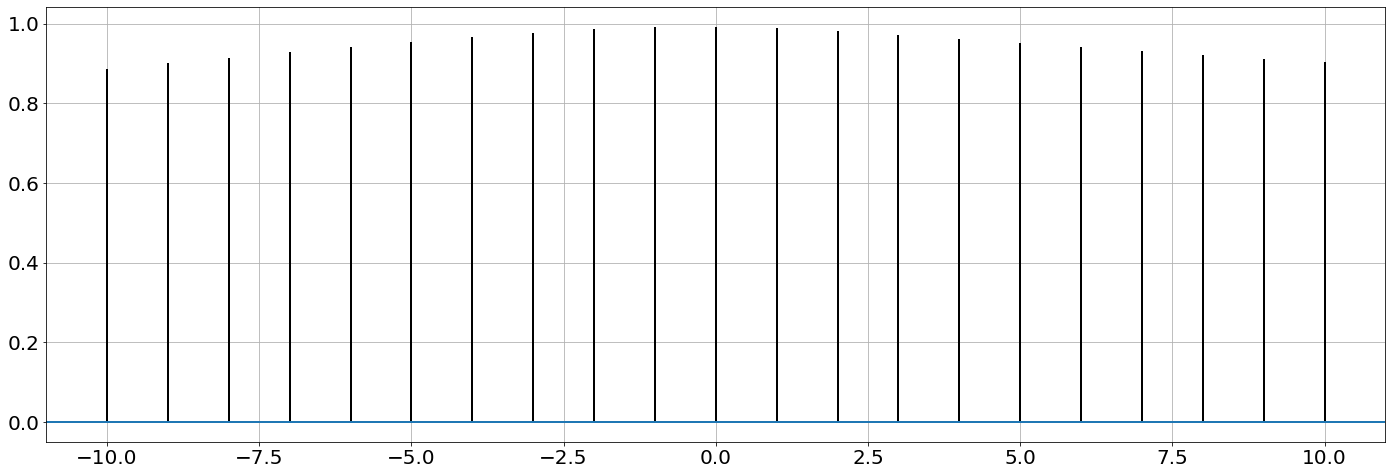

In [11]:
fig, ax = plt.subplots(figsize=(24,8))
(lags, c, _, _) = ax.xcorr(energy[energy['Week']==11]['Electricity'], energy[energy['Week']==17]['Electricity'], usevlines=True, maxlags=10, normed=True, lw=2)
ax.grid(True)

print(list(zip(c, lags)))

So there isn't a lagged correlation; if we inspect the data does it look like there should be?

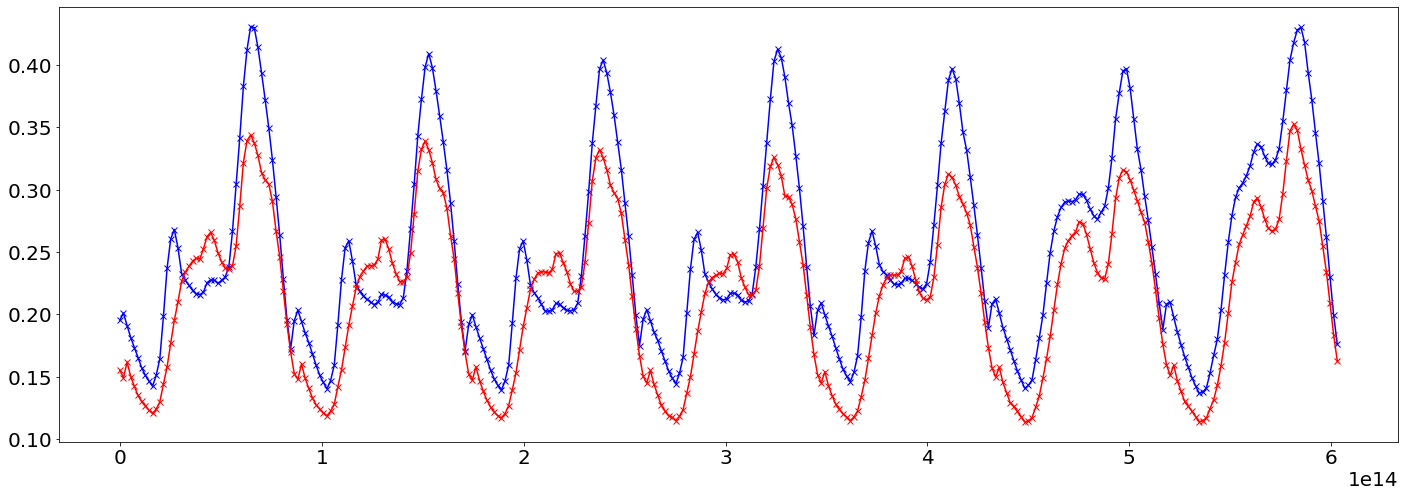

In [12]:
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(energy[energy['Week']==11]['Weektime'], energy[energy['Week']==11]['Electricity'], 'bx-')
ax.plot(energy[energy['Week']==17]['Weektime'], energy[energy['Week']==17]['Electricity'], 'rx-')

It does, but not in a way that a cross correlation will like; the "breakfast peak" and "phone in bed peak" looks later, but the "dinner peak" is looks earlier... How about if we just subtract one signal from the other?

(-0.1, 0.1)

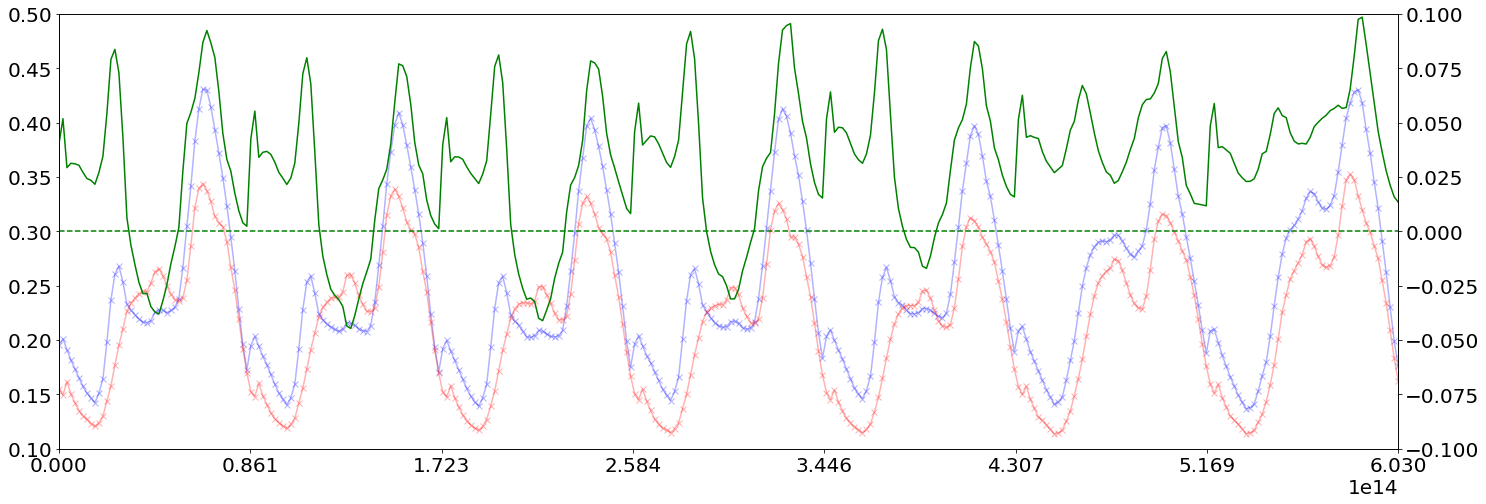

In [13]:
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(energy[energy['Week']==11]['Weektime'], energy[energy['Week']==11]['Electricity'], 'bx-', alpha=0.3)
ax.plot(energy[energy['Week']==17]['Weektime'], energy[energy['Week']==17]['Electricity'], 'rx-', alpha=0.3)
ax.set_xticks(np.linspace(0, 6.03e14, 8))
ax.set_ylim(0.1, 0.5)
ax.set_xlim(0, 6.03e14)

ax.axvline()

ax2 = ax.twinx()
ax2.plot(energy[energy['Week']==11]['Weektime'], energy[energy['Week']==11]['Electricity'].values-energy[energy['Week']==17]['Electricity'].values, 'g')
ax2.axhline(0, color='g', linestyle='--')
ax2.set_ylim(-0.1, 0.1)

In [14]:
from octopusdata import OctopusData
octopus = OctopusData(data_file='octopus/octopus.csv', weather_file='octopus/UK_weather.csv')

In [15]:
#octopus.get_data()
#octopus.get_data_average()

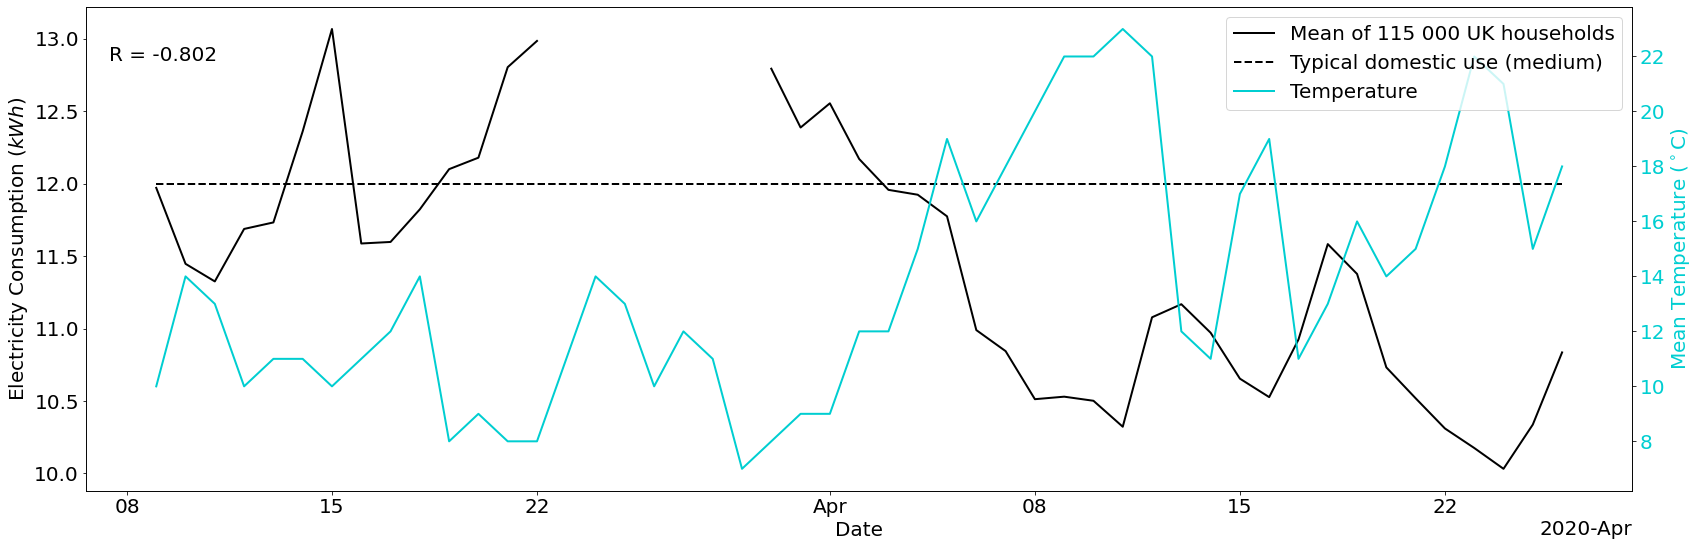

In [16]:
octopus.plot_daily_electricity(figsize=(24,8), plot_temperature=True, colors=['k', 'darkturquoise'])

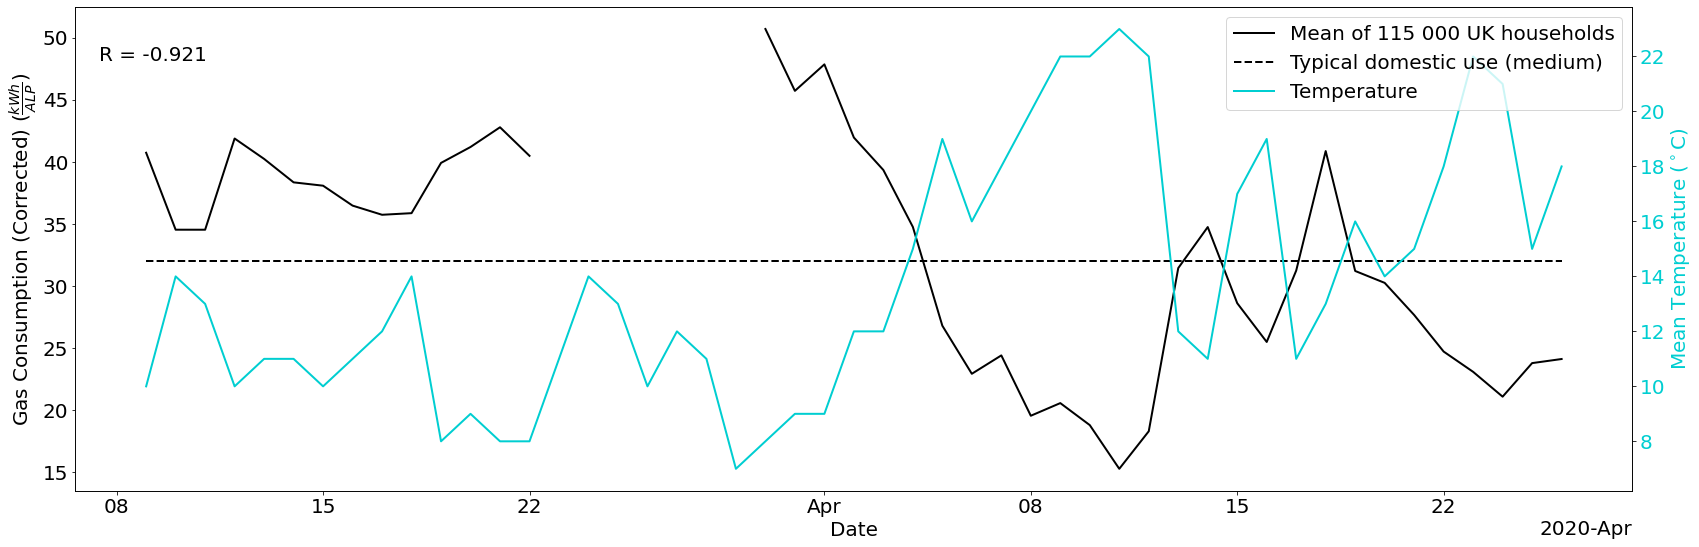

In [17]:
plt.rcParams.update({'font.size': 20})
octopus.plot_daily_gas(figsize=(24,8), plot_temperature=True, colors=['k', 'darkturquoise'])